### Libraries import

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [147]:
# Set global plot style
def set_plot_style():
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({
        "figure.figsize": (8, 4),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.edgecolor": "gray",
        "axes.titleweight": "bold",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.alpha": 0.3,
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "legend.frameon": False,
        "legend.loc": "best",
        "legend.fontsize": 10
    })
    sns.set_palette(sns.color_palette("magma"))  # softer palette globally
# Call once to apply
set_plot_style()
PRIMARY_BLUE = "#004e98"  # good default blue (RGB 31, 119, 180)
TAXI_YELLOW = "#FFD300"

def basic_barplot(series, title, xlabel="", ylabel="Number of Trips"):
    ax = series.plot(kind="bar", color=TAXI_YELLOW)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

pd.options.display.float_format = '{:,.2f}'.format

# Assignment B - Jakub Nowak & Mateusz Zbysław
## Taxi Trips (2013-2023) Chicago

# 1. Motivation
- Why taxi data from Chicago?
    We have decided to explore this specific dataset after careful consideration of available data sources. Firstly, we explored official data websites from the following cities: Copenhagen, Helsinki, Chicago, New York, Melboune and Sydney.
    Then we went through each of them and searched for interesting dataset that would contain valid social data.
    We had three picks and after discussion we agreed that Taxi data from Chicago will be the most interesting dataset that will allow us to ivestigate multiple aspects of taxi trips. We knew we can explore timeline, location, fares, distances, speed, number of trips etc. Moreover, gained insigts will most likely be understandable and realatable by an audience visiting our future website.
- Why is urban mobility important to understand?
    City transportation is a critical aspect of a modern city or metropoly. It shapes the flow of vehicles in the city. Understanding urban mobility allows to understand patterns and behaviour of people that use vehicles in the city. Insights can shape a foundation for upgrades that could be incorporated by urban planners, city governments, urban mobility companies or people - for choosing right path and type of transportation - to reach destination.
- What questions are you trying to answer?
    - How do taxi trips change year to year?
    - How do count, length, price, avg. speed, etc of trips change?
    - From where and to where people travel the most by taxi?
    - When (hour) is it most likely to receive a tip as taxi driver?
    - On which part of the city is it most likely to receive a tip as taxi driver?
    - As a passenger, which taxi company is the cheapest, when comapre same trip duration?
    - When am I most likely to need such a trip?
    - Does COVID 19 affect taxi trips? How? - count, length, fares, tips

- Inspiration (e.g., Ben Wellington-style urban insights)
    - TODO

# 2. Dataset Description
- Where it comes from (Chicago Open Data Portal)
Our dataset comes from the Chicago Open Data Portal.
https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/about_data

- Size of the original dataset: ~14.7 million rows, 15 columns
- Temporal coverage: 2013–2023
- Data types: numeric, temporal, geospatial

## Reducing dataset size #TODO

## Dataset import

In [148]:
pathLaptop = "C:/Users/mateu/OneDrive - Danmarks Tekniske Universitet/socialdata/Taxi_Trips_cleaned.csv"
pathPC = "E:/Taxi_Trips_cleaned.csv"
df = pd.read_csv(
    pathPC,
    low_memory=False
)

Inspection of first and last 5 rows.

In [149]:
df

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,06/29/2019 11:00:00 PM,06/29/2019 11:15:00 PM,307.00,0.40,4.75,0.00,0.00,1.00,5.75,Cash,Chicago Taxicab,41.89,-87.63,41.89,-87.63
1,03/31/2023 07:45:00 AM,03/31/2023 08:30:00 AM,"2,161.00",8.98,30.00,0.00,0.00,1.00,31.00,Prcard,Flash Cab,41.76,-87.57,41.66,-87.60
2,09/14/2020 03:15:00 PM,09/14/2020 03:30:00 PM,"1,368.00",2.87,13.75,0.00,0.00,0.00,13.75,Prcard,Flash Cab,41.76,-87.57,41.76,-87.57
3,09/26/2020 12:45:00 AM,09/26/2020 01:00:00 AM,780.00,4.70,15.00,0.00,0.00,0.00,15.00,Cash,Top Cab Affiliation,41.90,-87.63,41.94,-87.66
4,08/21/2022 07:45:00 PM,08/21/2022 08:15:00 PM,"2,004.00",15.45,39.50,9.00,0.00,5.00,54.00,Mobile,Globe Taxi,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14705769,01/07/2015 06:30:00 PM,01/07/2015 06:30:00 PM,0.00,0.00,7.85,2.00,0.00,0.00,9.85,Credit Card,Suburban Dispatch LLC,NaN,NaN,NaN,NaN
14705770,07/31/2015 08:00:00 PM,07/31/2015 08:00:00 PM,0.00,0.00,7.75,1.55,0.00,0.00,9.30,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN
14705771,08/13/2015 10:15:00 AM,08/13/2015 10:15:00 AM,0.00,0.00,40.05,8.01,0.00,0.00,48.06,Credit Card,Suburban Dispatch LLC,NaN,NaN,NaN,NaN
14705772,09/18/2019 07:45:00 PM,09/18/2019 07:45:00 PM,0.00,0.00,3.50,0.00,0.00,0.00,3.50,Cash,Taxi Affiliation Services,41.88,-87.62,41.88,-87.62


We observe that:
- rows are not sorted by timestamp
- multiple rows do not contain data (NaNs)

## Basic info

In [150]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14705774 entries, 0 to 14705773
Data columns (total 15 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip Start Timestamp        object 
 1   Trip End Timestamp          object 
 2   Trip Seconds                float64
 3   Trip Miles                  float64
 4   Fare                        float64
 5   Tips                        float64
 6   Tolls                       float64
 7   Extras                      float64
 8   Trip Total                  float64
 9   Payment Type                object 
 10  Company                     object 
 11  Pickup Centroid Latitude    float64
 12  Pickup Centroid Longitude   float64
 13  Dropoff Centroid Latitude   float64
 14  Dropoff Centroid Longitude  float64
dtypes: float64(11), object(4)
memory usage: 1.6+ GB


,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,"14,703,607.00","14,705,523.00","14,703,761.00","14,703,761.00","12,086,885.00","14,703,761.00","14,703,761.00","13,214,334.00","13,214,334.00","12,955,889.00","12,955,889.00"
mean,853.85,3.89,14.46,1.68,0.01,1.16,17.38,41.90,-87.66,41.90,-87.66
std,"1,322.48",12.37,40.39,3.01,3.83,18.47,45.87,0.04,0.08,0.04,0.06
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,41.65,-87.91,41.65,-87.91
25%,354.00,0.60,6.05,0.00,0.00,0.00,7.25,41.88,-87.66,41.88,-87.66
50%,599.00,1.39,8.50,0.00,0.00,0.00,10.25,41.89,-87.63,41.89,-87.63
75%,"1,029.00",3.78,15.50,2.00,0.00,1.00,18.00,41.91,-87.63,41.91,-87.63
max,"86,399.00","3,460.00","9,900.26",930.00,"6,466.66","9,850.30","9,948.47",42.02,-87.53,42.02,-87.53


We observe that:
- timestamp coulmns are recognized as type of objects similarly, payment type and company
- minimum value of trip duration, trip miles, fare, tips, tools, extras and trip total is 0 which can indicate wrongly registered trips
- range of registered trips is
    Longitude: -87.91 to -87.53
    Latitude: 41.65 to 42.02

# 3. Data Cleaning and Preprocessing
- Parsing timestamps
- Creating trip duration, tip rate, average speed
- Handling NaNs
- Filtering outliers (e.g., trips over 100 mph, or 0-mile trips)

## 3.1 Feature engineering for preprocessing, exploration and data cleaning

In [151]:
# 2. Parse timestamps
df["Trip Start Timestamp"] = pd.to_datetime(
    df["Trip Start Timestamp"],
    format="%m/%d/%Y %I:%M:%S %p",  # adjust if your format differs
    errors="coerce"  # will turn bad rows into NaT
)
df["Trip End Timestamp"] = pd.to_datetime(
    df["Trip End Timestamp"],
    format="%m/%d/%Y %I:%M:%S %p",
    errors="coerce"
)

# 3. Drop rows with missing critical datetime info
df.dropna(subset=["Trip Start Timestamp", "Trip End Timestamp"], inplace=True)

# 4. Add engineered features
df["trip_duration_min"] = (df["Trip End Timestamp"] - df["Trip Start Timestamp"]).dt.total_seconds() / 60
df["avg_speed_mph"] = df["Trip Miles"] / (df["trip_duration_min"] / 60)
df["tip_rate"] = df["Tips"] / df["Fare"]

# 5. Extract time-based features for analysis
df["start_year"] = df["Trip Start Timestamp"].dt.year
df["start_month"] = df["Trip Start Timestamp"].dt.month
df["start_hour"] = df["Trip Start Timestamp"].dt.hour
df["start_weekday"] = df["Trip Start Timestamp"].dt.day_name()
df["end_year"] = df["Trip End Timestamp"].dt.year
df["end_month"] = df["Trip End Timestamp"].dt.month
df["end_hour"] = df["Trip End Timestamp"].dt.hour
df["end_weekday"] = df["Trip End Timestamp"].dt.day_name()

## 3.2 Outlier exploration & handling

Before filtering the data, we conducted an outlier analysis to identify extreme or potentially invalid values. These outliers could distort trends and visualizations if left in.
Here’s what we found across the dataset.

Visual outlier inspection

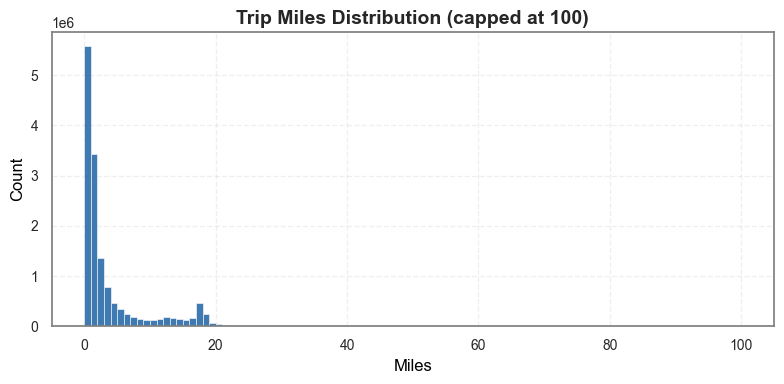

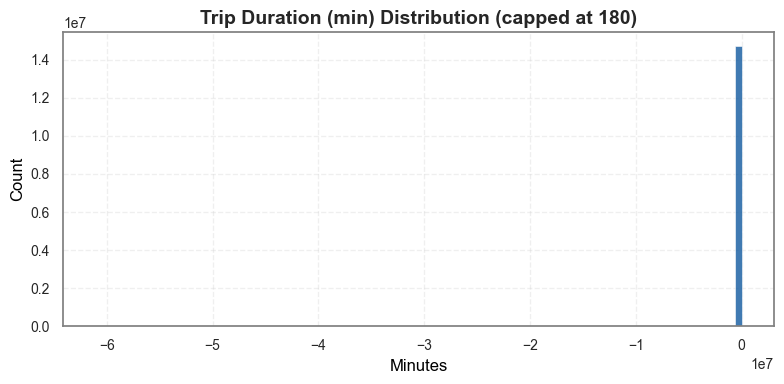

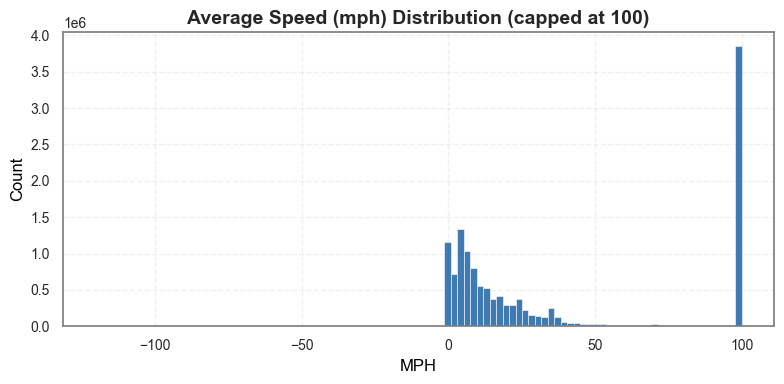

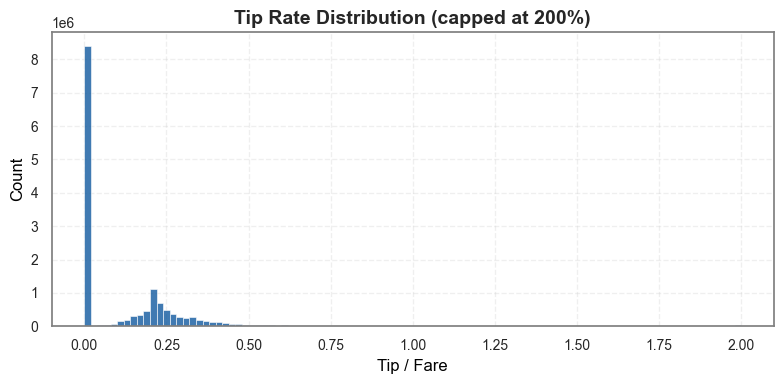

In [159]:
# Helper to cap extreme values
def cap(series, upper):
    return series.clip(upper=upper)

# 1. Trip Miles
sns.histplot(cap(df["Trip Miles"], 100), bins=100, color=PRIMARY_BLUE)
plt.title("Trip Miles Distribution (capped at 100)")
plt.xlabel("Miles")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Trip Duration
sns.histplot(cap(df["trip_duration_min"], 180), bins=100, color=PRIMARY_BLUE)
plt.title("Trip Duration (min) Distribution (capped at 180)")
plt.xlabel("Minutes")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3. Average Speed
sns.histplot(cap(df["avg_speed_mph"], 100), bins=100, color=PRIMARY_BLUE)
plt.title("Average Speed (mph) Distribution (capped at 100)")
plt.xlabel("MPH")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4. Tip Rate
sns.histplot(cap(df["tip_rate"], 2), bins=100, color=PRIMARY_BLUE)
plt.title("Tip Rate Distribution (capped at 200%)")
plt.xlabel("Tip / Fare")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Quantify outliers

In [153]:
# Total rows
total = len(df)

# 1. Zero or near-zero distance or duration
zero_miles = df[df["Trip Miles"] < 0.1]
short_duration = df[df["trip_duration_min"] < 1]

# 2. Super fast or super slow
too_fast = df[df["avg_speed_mph"] > 100]
too_slow = df[df["avg_speed_mph"] < 1]

# 3. Huge fares or tips
huge_fares = df[df["Fare"] > 500]
huge_tips = df[df["Tips"] > 100]

# Print summary
print("Outlier Summary:")
print(f"Zero-mile trips: {len(zero_miles):,} ({len(zero_miles)/total:.2%})")
print(f"Short-duration trips: {len(short_duration):,} ({len(short_duration)/total:.2%})")
print(f"Avg speed > 100 mph: {len(too_fast):,} ({len(too_fast)/total:.2%})")
print(f"Avg speed < 1 mph: {len(too_slow):,} ({len(too_slow)/total:.2%})")
print(f"Fare > $500: {len(huge_fares):,} ({len(huge_fares)/total:.2%})")
print(f"Tips > $100: {len(huge_tips):,} ({len(huge_tips)/total:.2%})")

Outlier Summary:
Zero-mile trips: 2,356,331 (16.02%)
Short-duration trips: 5,340,276 (36.32%)
Avg speed > 100 mph: 3,847,486 (26.16%)
Avg speed < 1 mph: 1,162,758 (7.91%)
Fare > $500: 1,236 (0.01%)
Tips > $100: 117 (0.00%)


We observe a non-trivial number of very slow trips (over 346,000, or 4.06%). These likely represent:
- trips with excessive waiting time (e.g. in traffic),
- incorrectly logged durations,
- or short trips left running.

We also found a small number of zero-distance trips, which may stem from GPS logging errors or canceled rides.

No trips exceeded 100 mph or were logged under 1 minute, which suggests the data is largely clean from major entry errors or sensor glitches in those areas.

## 3.3 Missing Values exploration & handling
To better understand the quality of the dataset before preprocessing, we inspected missing (NaN) values across all columns.

Below is a breakdown of how many values are missing in each column, both in absolute numbers and as a percentage of the full dataset.

This helps identify whether rows should be dropped or whether imputation might be necessary.

- Columns with GPS data (pickup/dropoff coordinates) are often missing — possibly due to technical limitations or privacy masking.
- Financial columns (fare, tips, tolls) rarely contain NaNs but need verification.
- Missing categorical values (like payment type or company) are rare but should be dropped for clean aggregations.

,Column,Missing Values,Percent of All Rows
4,Tolls,2618889,17.81
10,Dropoff Centroid Latitude,1748980,11.89
11,Dropoff Centroid Longitude,1748980,11.89
12,avg_speed_mph,1503922,10.23
8,Pickup Centroid Latitude,1491382,10.14
9,Pickup Centroid Longitude,1491382,10.14
7,Company,1315681,8.95
13,tip_rate,12369,0.08
2,Fare,2013,0.01
3,Tips,2013,0.01


C:\Users\IZO21\AppData\Local\Temp\ipykernel_15880\767962893.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


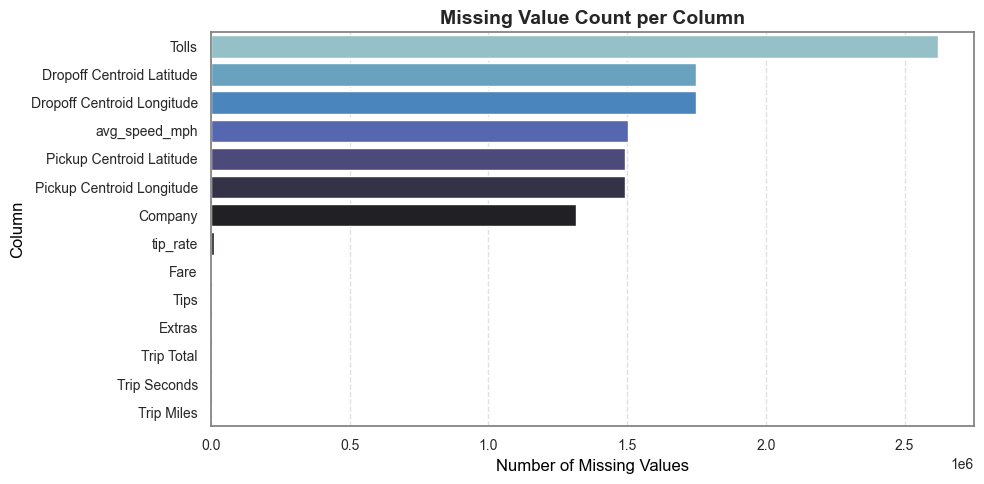

In [158]:
nan_counts = df.isna().sum()
nan_counts = nan_counts[nan_counts > 0]

nan_df = pd.DataFrame({
    "Column": nan_counts.index,
    "Missing Values": nan_counts.values,
    "Percent of All Rows": (nan_counts.values / len(df)) * 100
}).sort_values("Missing Values", ascending=False)

display(nan_df)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=nan_df,
    y="Column", x="Missing Values",
    palette="icefire"
)
plt.title("Missing Value Count per Column")
plt.xlabel("Number of Missing Values")
plt.ylabel("Column")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Most missing values appear in geospatial (Pickup/Dropoff coordinates) and derived columns like avg_speed_mph and tip_rate. These are expected due to GPS limitations or missing base values and will only be excluded in map-based analysis. Tolls (~18%) is often missing when no toll was paid and will be imputed as 0. The Company field (~9%) may reflect unaffiliated drivers and will be dropped when analyzing company trends. Financial columns (Fare, Tips, Trip Total) and core trip info (Trip Miles, Trip Seconds) have very low missingness and will be dropped when needed.

Strategy:
Drop rows missing critical fields like timestamps, fare, and company. Impute Tolls, Extras, and Tips as 0 where valid. Recalculate derived fields after cleaning. Only filter GPS-related rows in visualizations requiring location data.

## 3.4 Data cleaning - based on exploration

In [160]:
# 6. Remove outliers and garbage trips
df = df[
    (df["Trip Miles"] >= 0.1) &
    (df["trip_duration_min"] >= 1) &
    (df["trip_duration_min"] <= 180) &
    (df["avg_speed_mph"] >= 1) &
    (df["avg_speed_mph"] <= 100) &
    (df["Fare"] > 0)
]
# 7. Clean tip rate (optional: cap at 100%)
df["tip_rate"] = df["tip_rate"].clip(upper=1)

# 8. Drop rows with critical missing values after filtering
df.dropna(subset=["Payment Type", "Company"], inplace=True)

# 9. (Optional) Reset index for clean export or slicing
df.reset_index(drop=True, inplace=True)

# Final confirmation
print("Final cleaned dataset shape:", df.shape)
print(df.dtypes)


C:\Users\IZO21\AppData\Local\Temp\ipykernel_15880\3856012650.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tip_rate"] = df["tip_rate"].clip(upper=1)


Final cleaned dataset shape: (7358897, 26)
Trip Start Timestamp          datetime64[ns]
Trip End Timestamp            datetime64[ns]
Trip Seconds                         float64
Trip Miles                           float64
Fare                                 float64
Tips                                 float64
Tolls                                float64
Extras                               float64
Trip Total                           float64
Payment Type                          object
Company                               object
Pickup Centroid Latitude             float64
Pickup Centroid Longitude            float64
Dropoff Centroid Latitude            float64
Dropoff Centroid Longitude           float64
trip_duration_min                    float64
avg_speed_mph                        float64
tip_rate                             float64
start_year                             int32
start_month                            int32
start_hour                             int32
start_weekda

C:\Users\IZO21\AppData\Local\Temp\ipykernel_15880\3856012650.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["Payment Type", "Company"], inplace=True)


In [161]:
df["Trip Start Timestamp"].min(), df["Trip End Timestamp"].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2024-01-01 00:45:00'))

In [162]:
# Impute Tolls with 0 where missing
df['Tolls'].fillna(0, inplace=True)

# Impute 'Extras' and 'Tips' with 0 where missing (if necessary)
df['Extras'].fillna(0, inplace=True)
df['Tips'].fillna(0, inplace=True)

# Drop rows where critical fields (Fare, Company, and GPS coordinates) are missing
df_cleaned = df.dropna(subset=['Trip Start Timestamp', 'Trip End Timestamp', 'Fare', 'Company', 
                               'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 
                               'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'])

# For columns with very few missing values (e.g., Trip Seconds, Trip Miles), drop rows where these are missing
df_cleaned = df_cleaned.dropna(subset=['Trip Seconds', 'Trip Miles'])

# Ensure all monetary columns (Fare, Trip Total, Tips, Tolls) have valid non-negative values
df_cleaned = df_cleaned[(df_cleaned['Fare'] >= 0) & (df_cleaned['Trip Total'] >= 0) & 
                        (df_cleaned['Tips'] >= 0) & (df_cleaned['Tolls'] >= 0)]

# Handle GPS-related missing data (either remove rows with missing values in GPS or impute)
# Since missing geospatial data could be excluded in spatial analysis, you may choose to drop or impute these
df_cleaned = df_cleaned.dropna(subset=['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 
                                       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'])

# Recalculate derived fields after cleaning
df_cleaned['avg_speed_mph'] = df_cleaned['Trip Miles'] / (df_cleaned['Trip Seconds'] / 3600)
df_cleaned['tip_rate'] = df_cleaned['Tips'] / df_cleaned['Fare']

# Recheck for NaN values after cleaning
print(f"NaN values afbefore cleaning:\n{df.isna().sum()}")
print(f"NaN values after cleaning:\n{df_cleaned.isna().sum()}")
df = df_cleaned.copy()

C:\Users\IZO21\AppData\Local\Temp\ipykernel_15880\1585691917.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tolls'].fillna(0, inplace=True)
C:\Users\IZO21\AppData\Local\Temp\ipykernel_15880\1585691917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tolls'].fillna(0, inplace=True)
C:\Users\IZO21\AppData\Local\Temp\ipykernel_158

NaN values afbefore cleaning:
Trip Start Timestamp               0
Trip End Timestamp                 0
Trip Seconds                       0
Trip Miles                         0
Fare                               0
Tips                               0
Tolls                              0
Extras                             0
Trip Total                         0
Payment Type                       0
Company                            0
Pickup Centroid Latitude      520679
Pickup Centroid Longitude     520679
Dropoff Centroid Latitude     719761
Dropoff Centroid Longitude    719761
trip_duration_min                  0
avg_speed_mph                      0
tip_rate                           0
start_year                         0
start_month                        0
start_hour                         0
start_weekday                      0
end_year                           0
end_month                          0
end_hour                           0
end_weekday                        0
dtype: i

# 4. Exploratory Data Analysis (EDA)

## 4.1 Initial basic exploration

A. General trip overview

In [163]:
# Total number of trips
print("Total valid trips:", len(df))
# Fare and trip distance summary
print(df[["Fare", "Trip Miles", "Trip Total", "tip_rate"]].describe())

Total valid trips: 6505971
              Fare   Trip Miles   Trip Total     tip_rate
count 6,505,971.00 6,505,971.00 6,505,971.00 6,505,971.00
mean         18.12         5.61        21.42         0.14
std          25.98         6.05        31.01         4.52
min           0.01         0.25         0.01         0.00
25%           7.85         1.30         9.25         0.00
50%          11.65         2.70        13.50         0.00
75%          25.75         8.00        28.50         0.22
max       9,006.87       225.00     9,672.11     4,900.00


B. Temporal trends

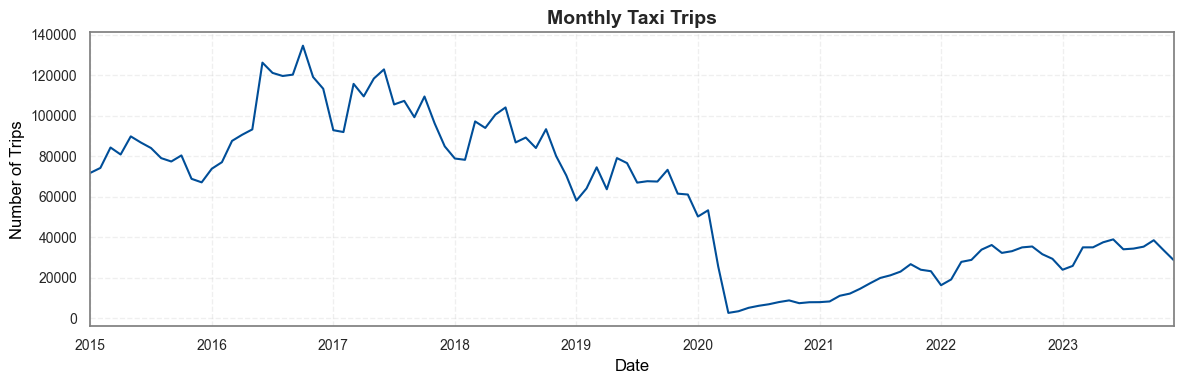

In [179]:
# 1. Group trips by year and month
monthly_trips = (
    df.groupby(["start_year", "start_month"])
    .size()
    .rename("trip_count")
    .reset_index()
)

# 2. Rename columns so pandas can parse them as a date
monthly_trips_for_date = monthly_trips[["start_year", "start_month"]].copy()
monthly_trips_for_date.columns = ["year", "month"]
monthly_trips_for_date["day"] = 1

# 3. Convert to datetime
monthly_trips["year_month"] = pd.to_datetime(monthly_trips_for_date)

# 4. Plot
monthly_trips.set_index("year_month")["trip_count"].plot(
    figsize=(12, 4),
    title="Monthly Taxi Trips", 
    color=PRIMARY_BLUE
)
plt.ylabel("Number of Trips")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

C. Tip behavior

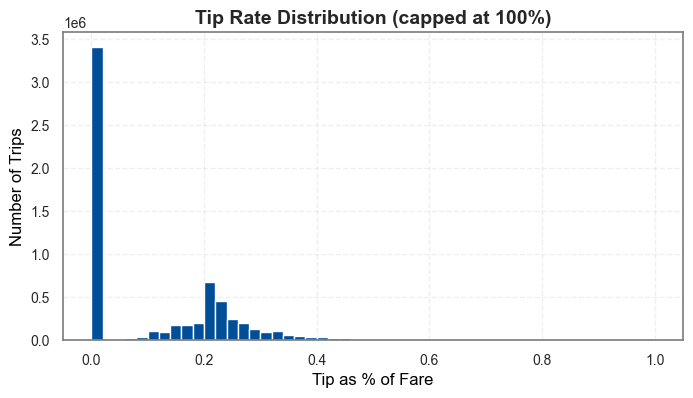

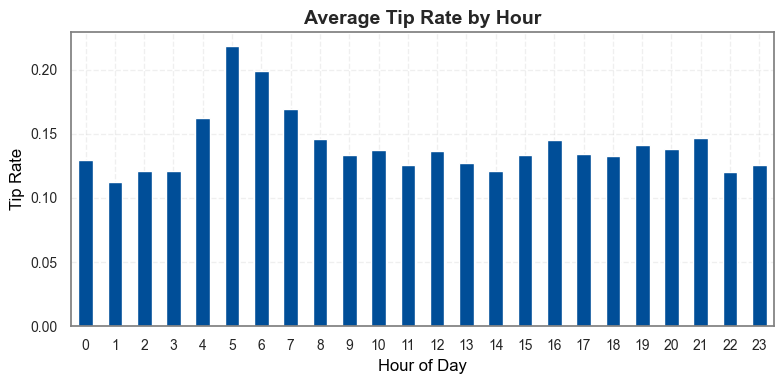

In [180]:
# Distribution of tip percentage
df["tip_rate"].clip(upper=1).hist(bins=50, figsize=(8,4), color=PRIMARY_BLUE)
plt.title("Tip Rate Distribution (capped at 100%)")
plt.xlabel("Tip as % of Fare")
plt.ylabel("Number of Trips")
plt.show()

# Average tip rate by hour of day
hourly_tip = df.groupby("start_hour")["tip_rate"].mean()
hourly_tip.plot(kind="bar", title="Average Tip Rate by Hour", color=PRIMARY_BLUE)
plt.ylabel("Tip Rate")
plt.xlabel("Hour of Day")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


D. Speed outliers

In [166]:
# Quick filter: which trips exceeded 70 mph?
fast_trips = df[df["avg_speed_mph"] > 70]

print("Trips faster than 70 mph:", len(fast_trips))
print(fast_trips[["Trip Miles", "trip_duration_min", "avg_speed_mph"]].head())

# Optional: remove absurd values for downstream analysis
df = df[(df["avg_speed_mph"] > 0) & (df["avg_speed_mph"] < 100)]


Trips faster than 70 mph: 9836
       Trip Miles  trip_duration_min  avg_speed_mph
1392         7.00              15.00          84.00
2485        12.02              15.00          71.64
11085       24.80              15.00         135.27
12544        6.00              15.00          90.00
13999       32.10              30.00          80.25


E. Trip distribution by weekday

In [167]:
df.columns

Index(['Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',
       'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'trip_duration_min', 'avg_speed_mph',
       'tip_rate', 'start_year', 'start_month', 'start_hour', 'start_weekday',
       'end_year', 'end_month', 'end_hour', 'end_weekday'],
      dtype='object')

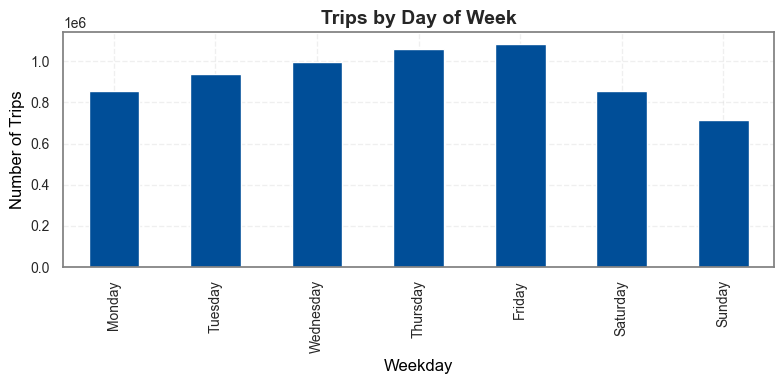

In [181]:
weekday_summary = df["start_weekday"].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

weekday_summary.plot(kind="bar", title="Trips by Day of Week", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Weekday")
plt.tight_layout()
plt.show()


F. Map of pickup locations (if lat/lon available)

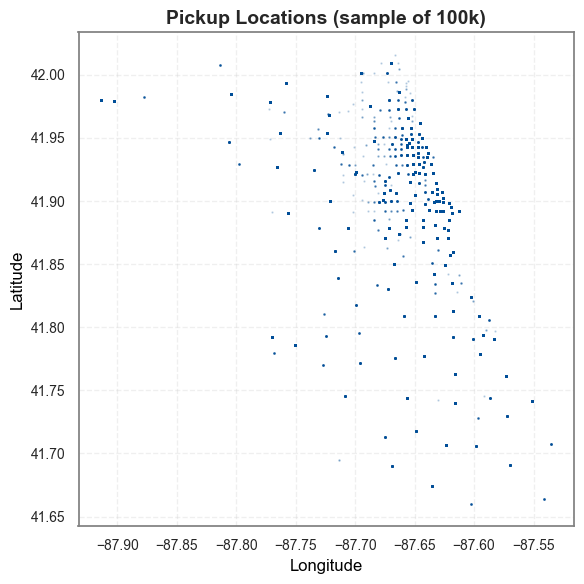

In [182]:
# Drop NaNs and take a sample for speed
pickup_sample = df.dropna(subset=["Pickup Centroid Latitude", "Pickup Centroid Longitude"]).sample(n=100000, random_state=1)

plt.figure(figsize=(6, 6))
plt.scatter(
    pickup_sample["Pickup Centroid Longitude"],
    pickup_sample["Pickup Centroid Latitude"],
    s=0.5, alpha=0.2, color=PRIMARY_BLUE
)
plt.title("Pickup Locations (sample of 100k)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


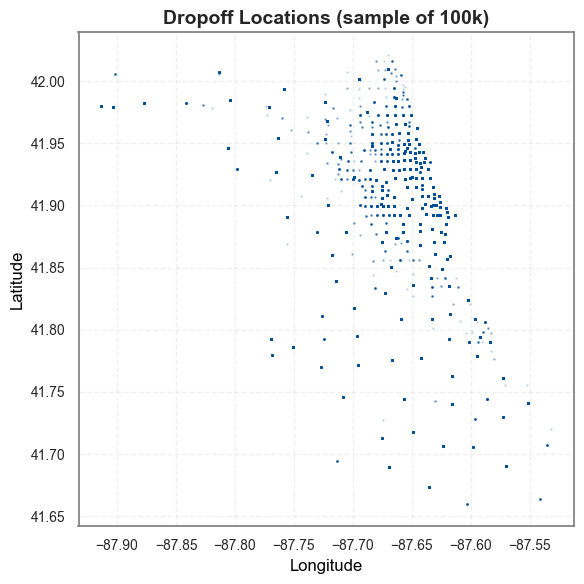

In [183]:
# Drop NaNs and take a sample for speed
dropoff_sample = df.dropna(subset=["Dropoff Centroid Latitude", "Dropoff Centroid Longitude"]).sample(n=100000, random_state=1)

plt.figure(figsize=(6, 6))
plt.scatter(
    dropoff_sample["Dropoff Centroid Longitude"],
    dropoff_sample["Dropoff Centroid Latitude"],
    s=0.5, alpha=0.2, color=PRIMARY_BLUE
)
plt.title("Dropoff Locations (sample of 100k)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


Trip duration vs. distance (does time scale with miles?)

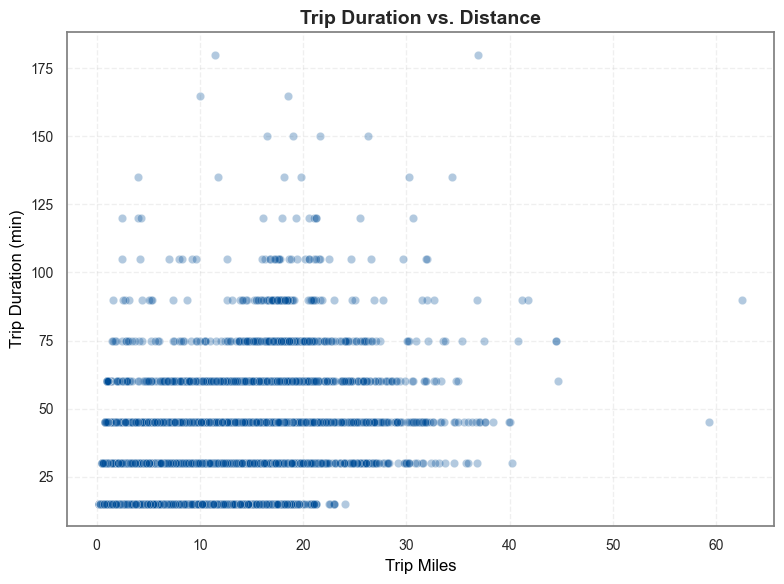

In [184]:
# Filter out zeros or NaNs
df_scatter = df[(df["Trip Miles"] > 0) & (df["trip_duration_min"] > 0)]

# Sample for plotting speed
df_sample = df_scatter.sample(n=50_000, random_state=1)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sample,
    x="Trip Miles", y="trip_duration_min", alpha=0.3, color=PRIMARY_BLUE
)
plt.title("Trip Duration vs. Distance")
plt.xlabel("Trip Miles")
plt.ylabel("Trip Duration (min)")
plt.tight_layout()
plt.show()


Top companies by trip count and average fare

                                 trip_count  avg_fare  avg_tip
Company                                                       
Flash Cab                           1041156     18.66     1.58
Taxi Affiliation Services           1025989     19.28     2.23
Yellow Cab                           509270     15.50     1.61
Chicago Carriage Cab Corp            467308     17.09     2.10
Sun Taxi                             395743     19.36     2.81
City Service                         382981     18.73     2.55
Medallion Leasin                     312074     18.34     2.30
Choice Taxi Association              266317     17.66     2.50
Dispatch Taxi Affiliation            254498     15.39     1.84
Taxi Affiliation Service Yellow      210814     17.28     2.03
Globe Taxi                           168014     18.13     2.35
Star North Management LLC            140045     16.58     2.27
American United                      114457     15.41     1.59
Northwest Management LLC              97041     14.66  

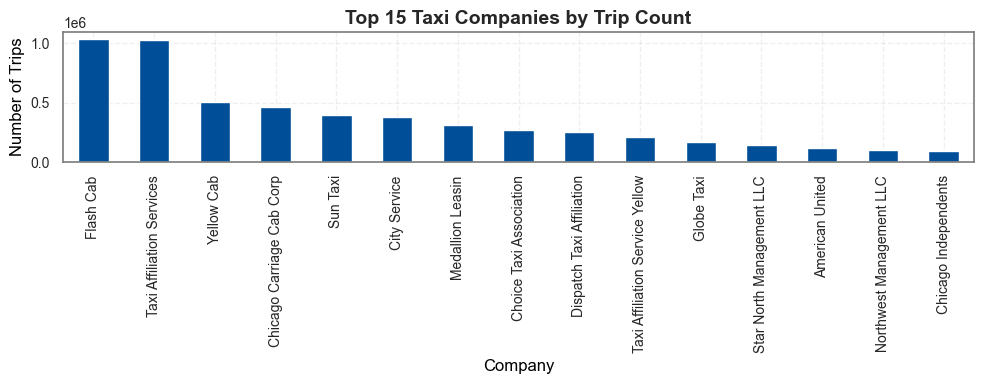

In [185]:
company_stats = (
    df.groupby("Company")
    .agg(
        trip_count = ("Trip Total", "count"),
        avg_fare = ("Fare", "mean"),
        avg_tip = ("Tips", "mean")
    )
    .sort_values("trip_count", ascending=False)
    .head(15)
)

print(company_stats)

# Plot top 15 companies by trip count
company_stats["trip_count"].plot(kind="bar", figsize=(10,4), title="Top 15 Taxi Companies by Trip Count", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Company")
plt.tight_layout()
plt.show()


Trips by payment type

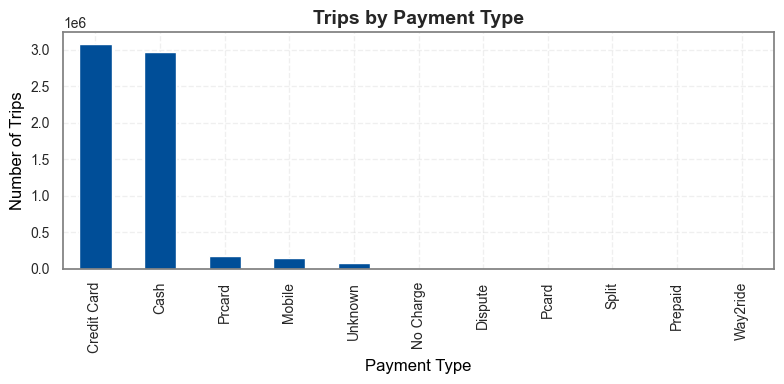

In [186]:
payment_summary = df["Payment Type"].value_counts()

payment_summary.plot(kind="bar", title="Trips by Payment Type", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Payment Type")
plt.tight_layout()
plt.show()


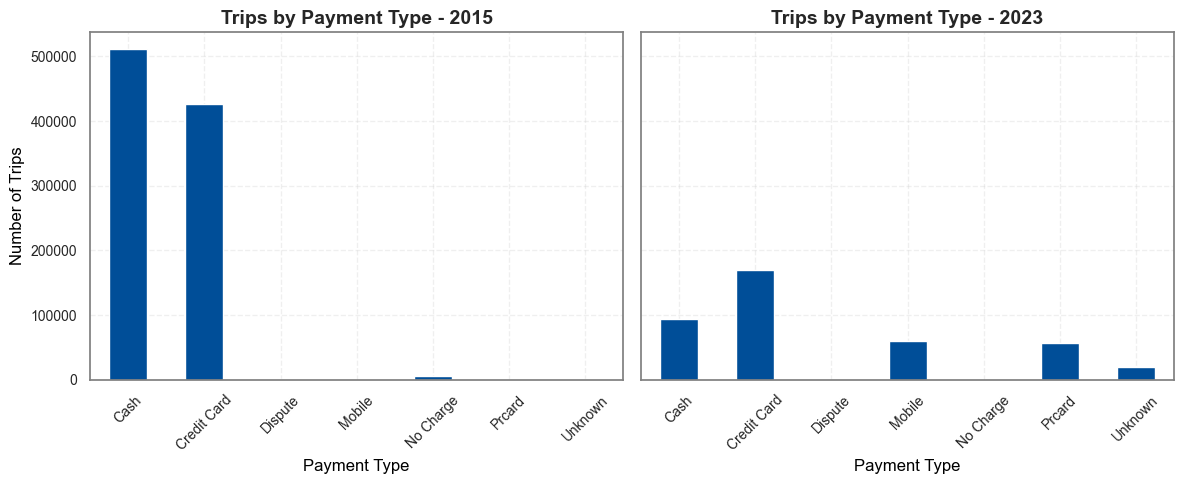

In [217]:
# Filter data for 2015 and 2023
df_2015 = df_cleaned[df_cleaned["start_year"] == 2015]
df_2023 = df_cleaned[df_cleaned["start_year"] == 2023]

# Get payment type distributions
payment_2015 = df_2015["Payment Type"].value_counts()
payment_2023 = df_2023["Payment Type"].value_counts()

# Align both series to ensure same order
all_payment_types = sorted(set(payment_2015.index).union(payment_2023.index))
payment_2015 = payment_2015.reindex(all_payment_types, fill_value=0)
payment_2023 = payment_2023.reindex(all_payment_types, fill_value=0)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

payment_2015.plot(kind="bar", ax=axes[0], color=PRIMARY_BLUE)
axes[0].set_title("Trips by Payment Type - 2015")
axes[0].set_ylabel("Number of Trips")
axes[0].set_xlabel("Payment Type")
axes[0].tick_params(axis="x", rotation=45)

payment_2023.plot(kind="bar", ax=axes[1], color=PRIMARY_BLUE)
axes[1].set_title("Trips by Payment Type - 2023")
axes[1].set_ylabel("")
axes[1].set_xlabel("Payment Type")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


Heatmap: hour vs. weekday (when are people riding?)

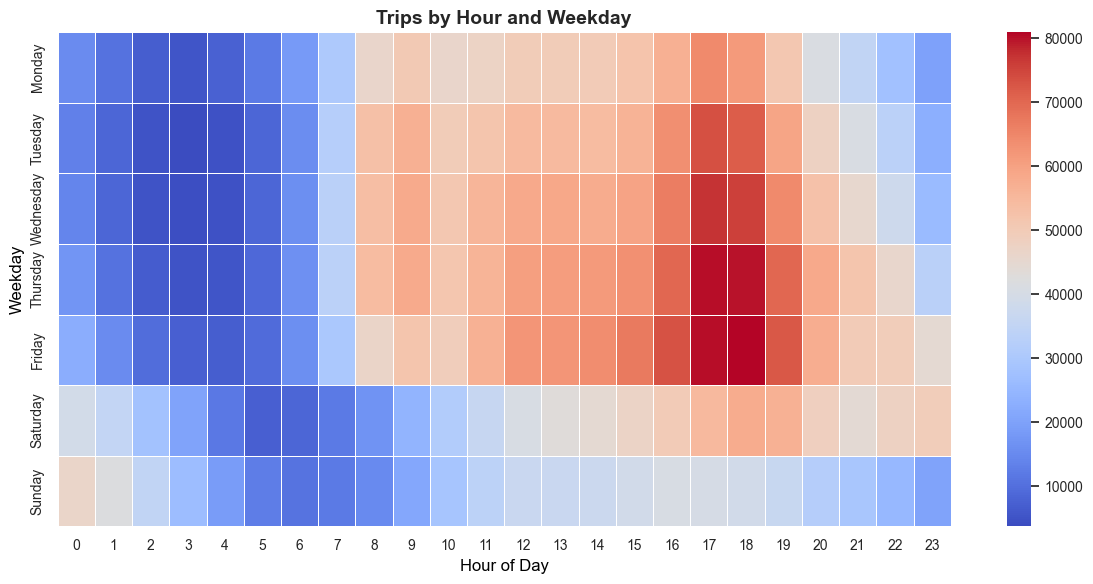

In [189]:
# Pivot: weekday (rows) vs. hour (columns)
heatmap_data = (
    df.groupby(["start_weekday", "start_hour"])
    .size()
    .unstack()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Trips by Hour and Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


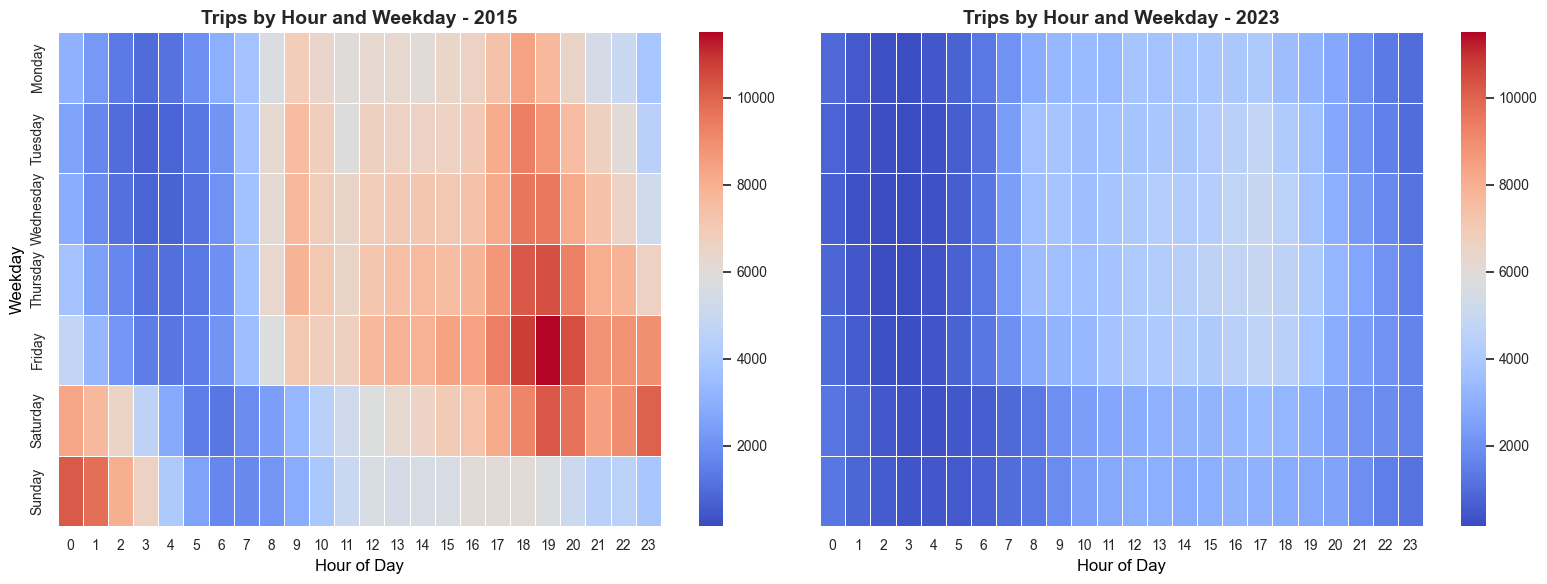

In [216]:
df_2015 = df_cleaned[df_cleaned["start_year"] == 2015]
df_2023 = df_cleaned[df_cleaned["start_year"] == 2023]

# Create the heatmap data: group by weekday and start_hour,
# then unstack so that weekdays are rows and hours are columns.
# We use "weekday" as defined earlier (day_name) and "start_hour".
order_weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

heatmap_2015 = (
    df_2015.groupby(["start_weekday", "start_hour"])
    .size()
    .unstack()
    .reindex(order_weekdays)
)

heatmap_2023 = (
    df_2023.groupby(["start_weekday", "start_hour"])
    .size()
    .unstack()
    .reindex(order_weekdays)
)

# Determine common limits for the color scale across both heatmaps,
# which helps with visual comparison.
vmin = min(heatmap_2015.min().min(), heatmap_2023.min().min())
vmax = max(heatmap_2015.max().max(), heatmap_2023.max().max())

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.heatmap(
    heatmap_2015,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    ax=axes[0],
    vmin=vmin, vmax=vmax
)
axes[0].set_title("Trips by Hour and Weekday - 2015")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Weekday")

sns.heatmap(
    heatmap_2023,
    cmap="coolwarm",
    annot=False,
    linewidths=0.5,
    ax=axes[1],
    vmin=vmin, vmax=vmax
)
axes[1].set_title("Trips by Hour and Weekday - 2023")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("")  # No need to duplicate the y-label

plt.tight_layout()
plt.show()


Detect unusually short or long trips

In [175]:
# Very short trips (<1 minute or <0.1 miles)
short_trips = df[(df["trip_duration_min"] < 1) | (df["Trip Miles"] < 0.1)]
print("Unusually short trips:", len(short_trips))

# Very long trips (>120 minutes or >50 miles)
long_trips = df[(df["trip_duration_min"] > 120) | (df["Trip Miles"] > 50)]
print("Unusually long trips:", len(long_trips))


Unusually short trips: 0
Unusually long trips: 2796


## 4.2 Temporal Patterns
- (monthly trends, weekday/hourly variation)

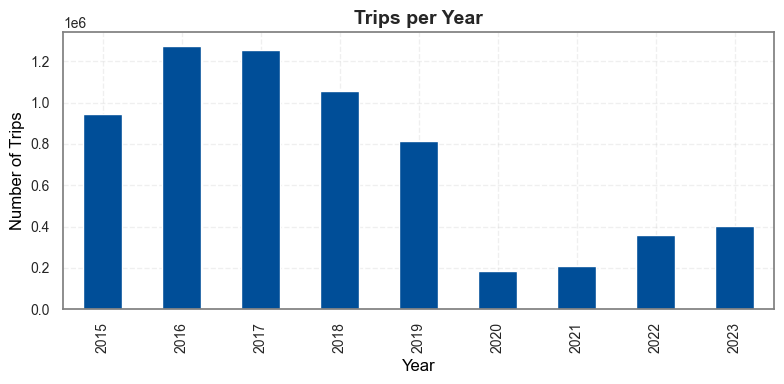

In [190]:
yearly = (
    df
    .groupby(df["Trip Start Timestamp"].dt.year)
    .size()
    .rename("num_trips")
)

yearly.plot(kind="bar", figsize=(8, 4), title="Trips per Year", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

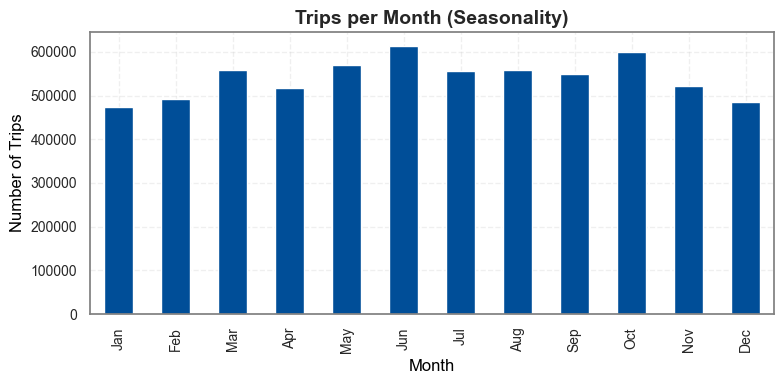

In [191]:
monthly = (
    df
    .groupby(df["Trip Start Timestamp"].dt.month)
    .size()
    .rename("num_trips")
)

monthly.index = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

monthly.plot(kind="bar", figsize=(8, 4), title="Trips per Month (Seasonality)", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Month")
plt.tight_layout()
plt.show()


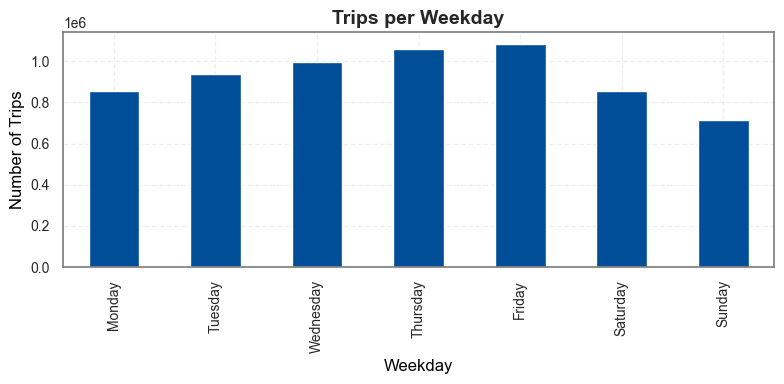

In [192]:
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

weekday = (
    df["start_weekday"]
    .value_counts()
    .reindex(weekday_order)
)

weekday.plot(kind="bar", figsize=(8, 4), title="Trips per Weekday", color=PRIMARY_BLUE)
plt.ylabel("Number of Trips")
plt.xlabel("Weekday")
plt.tight_layout()
plt.show()


## 4.3 Company Behavior
- (who dominates the market? who gets tipped more?)

In [193]:
company_stats = (
    df_cleaned.groupby("Company")
    .agg(
        trip_count=("Trip Total", "count"),
        avg_fare=("Fare", "mean"),
        avg_tip_rate=("tip_rate", "mean")
    )
    .sort_values("trip_count", ascending=False)
)

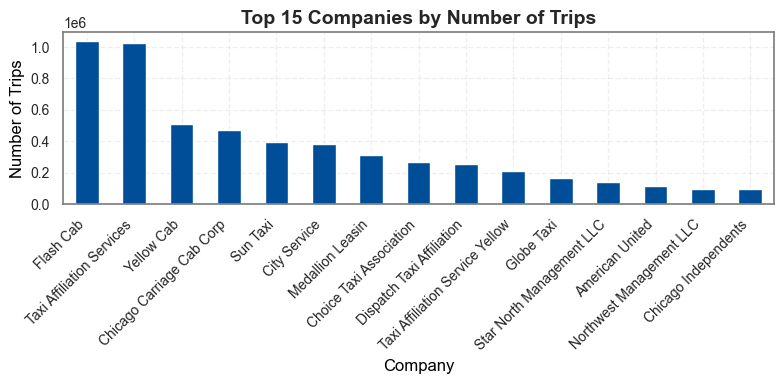

In [194]:
top15 = company_stats.head(15)

# Plot trip count
ax = top15["trip_count"].plot(kind="bar", color=PRIMARY_BLUE)
ax.set_title("Top 15 Companies by Number of Trips")
ax.set_ylabel("Number of Trips")
ax.set_xlabel("Company")
ax.set_xticklabels(top15.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()


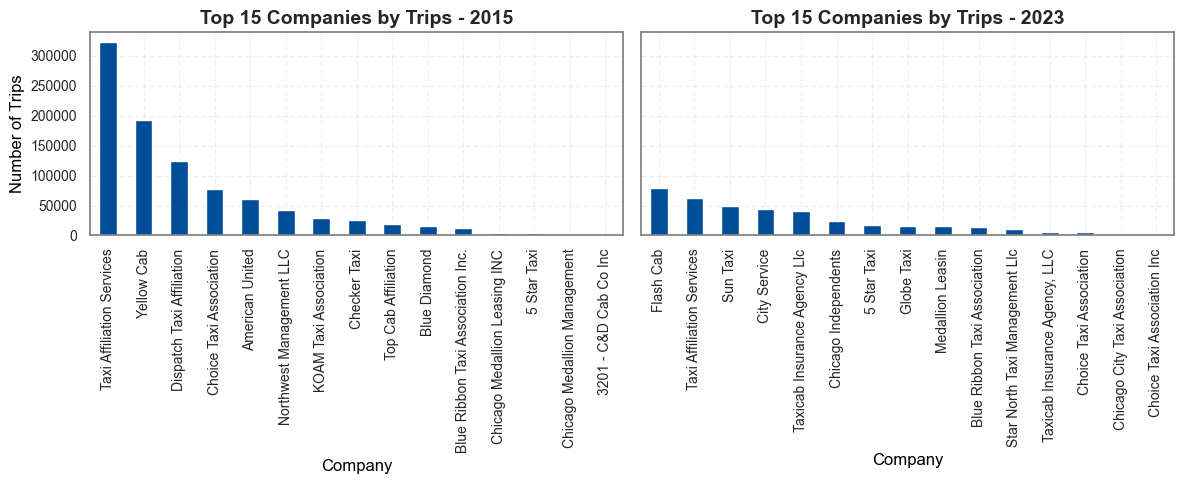

In [212]:
# Filter data for specific years
df_2015 = df_cleaned[df_cleaned["start_year"] == 2015]
df_2023 = df_cleaned[df_cleaned["start_year"] == 2023]

# Compute company trip counts per year
company_2015 = (
    df_2015.groupby("Company")
    .size()
    .rename("trip_count")
    .sort_values(ascending=False)
    .head(15)
)

company_2023 = (
    df_2023.groupby("Company")
    .size()
    .rename("trip_count")
    .sort_values(ascending=False)
    .head(15)
)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# 2015
company_2015.plot(kind="bar", ax=axes[0], color=PRIMARY_BLUE)
axes[0].set_title("Top 15 Companies by Trips - 2015")
axes[0].set_xlabel("Company")
axes[0].set_ylabel("Number of Trips")
axes[0].tick_params(axis="x")

# 2023
company_2023.plot(kind="bar", ax=axes[1], color=PRIMARY_BLUE)
axes[1].set_title("Top 15 Companies by Trips - 2023")
axes[1].set_xlabel("Company")
axes[1].tick_params(axis="x")

plt.tight_layout()
plt.show()


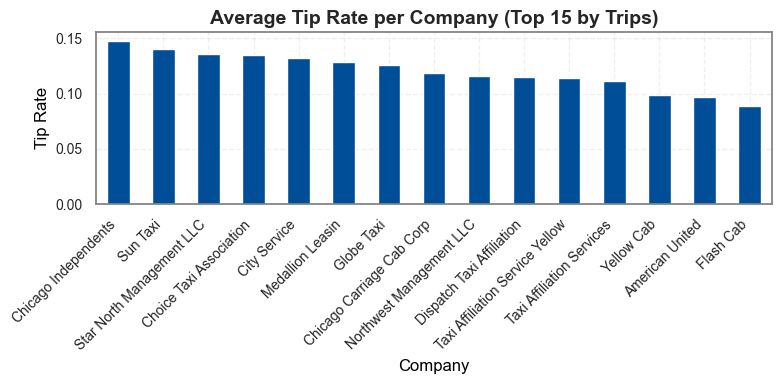

In [199]:
top15_sorted_by_tip = top15.sort_values("avg_tip_rate", ascending=False)

ax = top15_sorted_by_tip["avg_tip_rate"].plot(kind="bar", color=PRIMARY_BLUE)
ax.set_title("Average Tip Rate per Company (Top 15 by Trips)")
ax.set_ylabel("Tip Rate")
ax.set_xlabel("Company")
ax.set_xticklabels(top15_sorted_by_tip.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [204]:
import plotly.express as px

filtered = company_stats[company_stats["trip_count"] > 10_000].copy()
filtered["Company"] = filtered.index

fig = px.scatter(
    filtered,
    x="trip_count",
    y="avg_tip_rate",
    size="avg_fare",
    color="Company",
    hover_name="Company",
    title="Company Popularity vs. Tip Rate (Bubble Size = Avg Fare)"
)

# 🔧 Fix hover template (show % properly)
fig.update_traces(
    hovertemplate=(
        "<b>%{hovertext}</b><br>" +
        "Trips: %{x:,}<br>" +
        "Avg Tip Rate: %{y:.2%}<br>" +
        "Avg Fare: %{marker.size:.2f}<extra></extra>"
    )
)

# 🎨 Layout and style
fig.update_layout(
    xaxis_title="Number of Trips",
    yaxis_title="Average Tip Rate",
    template="simple_white",
    font=dict(size=12),
    legend_title_text="Company"
)

fig.show()


## 4.4 Payment Types

## 4.5 Geographic Spread 
- pickup/dropoff density, optionally with maps

In [ ]:
df_geo = df_cleaned.dropna(subset=[
    "Pickup Centroid Latitude", "Pickup Centroid Longitude",
    "Dropoff Centroid Latitude", "Dropoff Centroid Longitude"
])

In [207]:
import plotly.express as px

# Sample 20k rows for speed
pickup_sample = df_geo.sample(20_000, random_state=42)

fig = px.scatter_mapbox(
    pickup_sample,
    lat="Pickup Centroid Latitude",
    lon="Pickup Centroid Longitude",
    zoom=10,
    height=600,
    opacity=0.3,
    title="Pickup Locations in Chicago",
    mapbox_style="carto-positron"
)

fig.show()

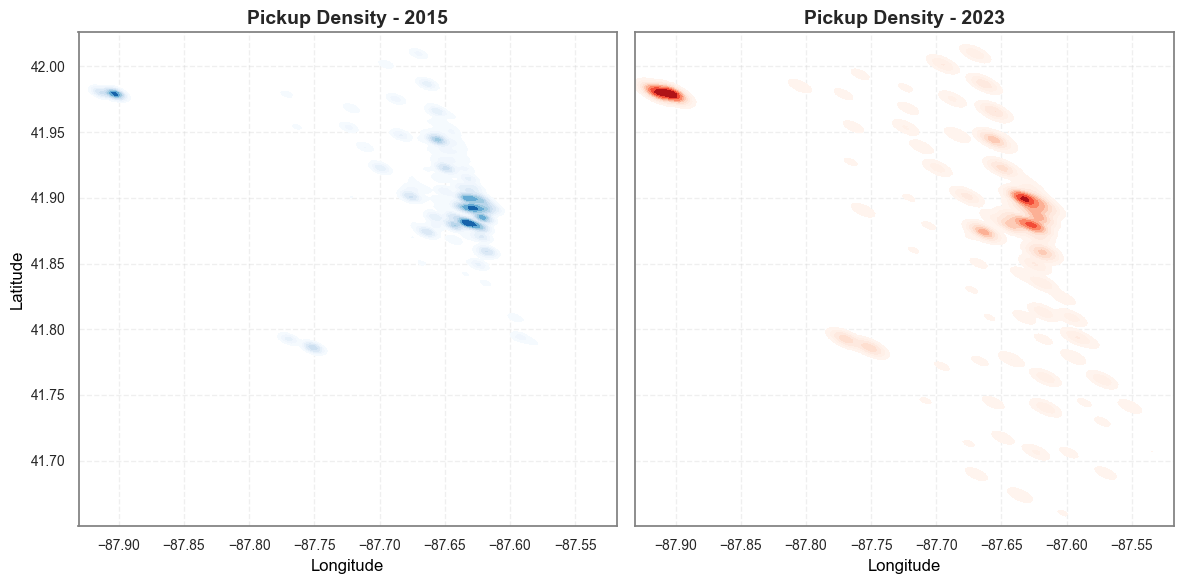

In [209]:
# Example: filter two different years
pickup_2015 = df_geo[df_geo["start_year"] == 2015].sample(50_000, random_state=1)
pickup_2023 = df_geo[df_geo["start_year"] == 2023].sample(50_000, random_state=2)
# Compare KDEs side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

sns.kdeplot(
    data=pickup_2015, ax=axes[0],
    x="Pickup Centroid Longitude", y="Pickup Centroid Latitude",
    cmap="Blues", fill=True, thresh=0.05, bw_adjust=0.3
)
axes[0].set_title("Pickup Density - 2015")

sns.kdeplot(
    data=pickup_2023, ax=axes[1],
    x="Pickup Centroid Longitude", y="Pickup Centroid Latitude",
    cmap="Reds", fill=True, thresh=0.05, bw_adjust=0.3
)
axes[1].set_title("Pickup Density - 2023")

for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

## 4.6 Fare, Duration, Distance Distributions

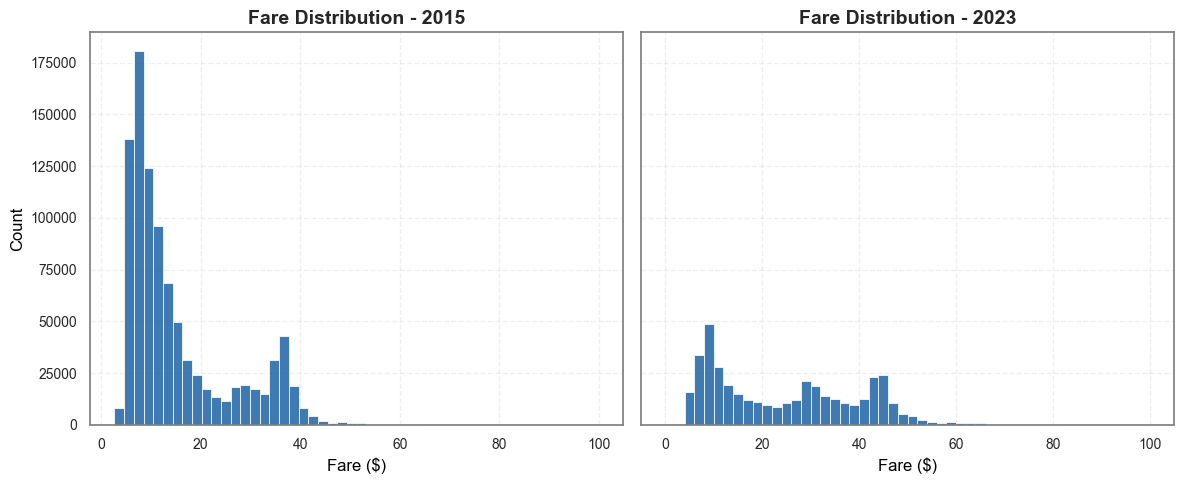

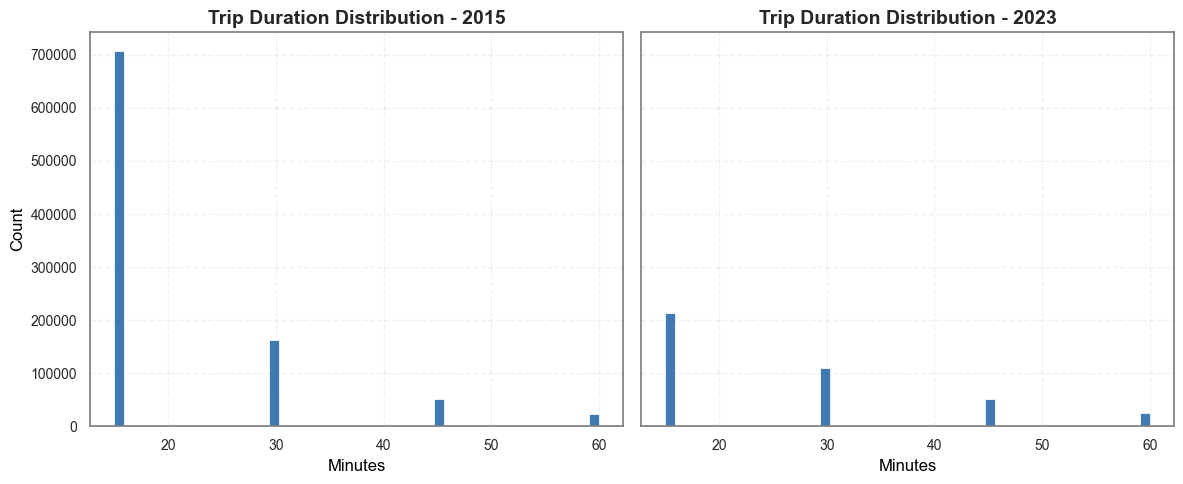

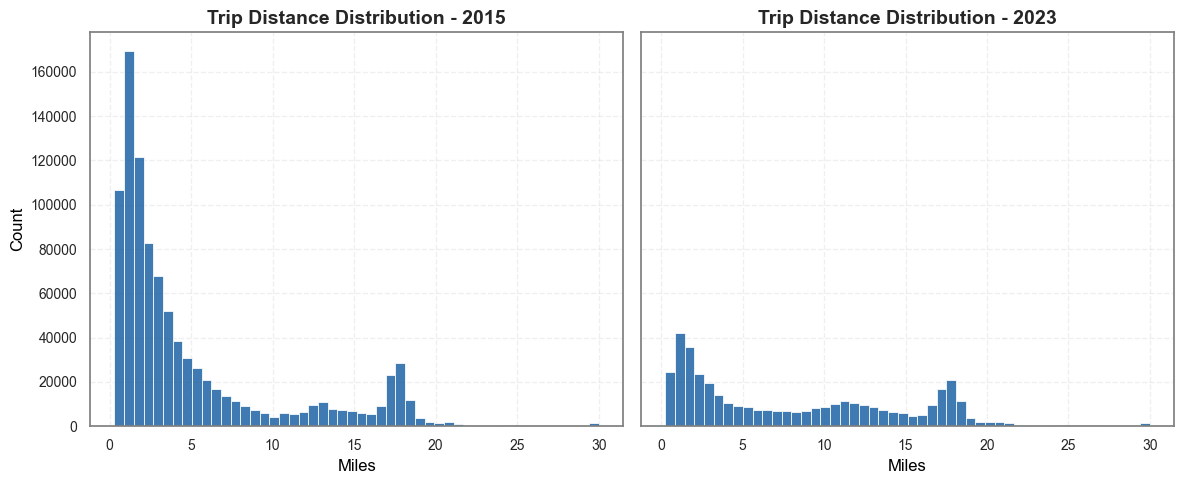

In [218]:
# Filter data for both years
df_2015 = df_cleaned[df_cleaned["start_year"] == 2015].copy()
df_2023 = df_cleaned[df_cleaned["start_year"] == 2023].copy()

# Cap outliers to avoid long tails in plot
df_2015["Fare Capped"] = df_2015["Fare"].clip(upper=100)
df_2023["Fare Capped"] = df_2023["Fare"].clip(upper=100)

df_2015["Duration Capped"] = df_2015["trip_duration_min"].clip(upper=60)
df_2023["Duration Capped"] = df_2023["trip_duration_min"].clip(upper=60)

df_2015["Distance Capped"] = df_2015["Trip Miles"].clip(upper=30)
df_2023["Distance Capped"] = df_2023["Trip Miles"].clip(upper=30)
def compare_distributions(var, label, unit, bins):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    sns.histplot(df_2015[var], bins=bins, ax=axes[0], color=PRIMARY_BLUE)
    axes[0].set_title(f"{label} Distribution - 2015")
    axes[0].set_xlabel(unit)
    axes[0].set_ylabel("Count")

    sns.histplot(df_2023[var], bins=bins, ax=axes[1], color=PRIMARY_BLUE)
    axes[1].set_title(f"{label} Distribution - 2023")
    axes[1].set_xlabel(unit)

    plt.tight_layout()
    plt.show()
compare_distributions("Fare Capped", "Fare", "Fare ($)", bins=50)
compare_distributions("Duration Capped", "Trip Duration", "Minutes", bins=50)
compare_distributions("Distance Capped", "Trip Distance", "Miles", bins=50)


# 5. Machine learning 
- Predicting total number of trips per year
- Predicting average fare per year

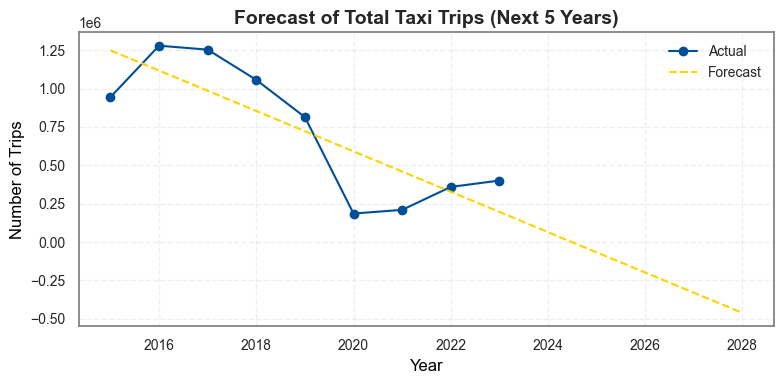

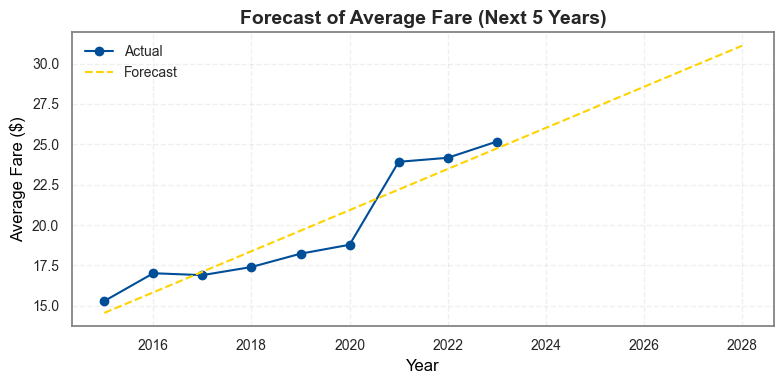

In [219]:
# Total trips per year
trips_per_year = (
    df_cleaned.groupby("start_year")
    .size()
    .rename("num_trips")
    .reset_index()
)

# Average fare per year
fare_per_year = (
    df_cleaned.groupby("start_year")["Fare"]
    .mean()
    .rename("avg_fare")
    .reset_index()
)
from sklearn.linear_model import LinearRegression
import numpy as np

# Define helper to fit and predict
def fit_and_forecast(df, x_col, y_col, years_forward=5):
    model = LinearRegression()
    
    # Reshape X and fit model
    X = df[[x_col]].values
    y = df[y_col].values
    model.fit(X, y)
    
    # Forecast future years
    last_year = df[x_col].max()
    future_years = np.arange(last_year + 1, last_year + 1 + years_forward)
    all_years = np.append(df[x_col].values, future_years)
    
    # Predict
    y_pred = model.predict(all_years.reshape(-1, 1))
    return all_years, y_pred
years_trips, predicted_trips = fit_and_forecast(trips_per_year, "start_year", "num_trips")

plt.figure(figsize=(8, 4))
plt.plot(trips_per_year["start_year"], trips_per_year["num_trips"], label="Actual", marker='o', color=PRIMARY_BLUE)
plt.plot(years_trips, predicted_trips, label="Forecast", linestyle="--", color=TAXI_YELLOW)
plt.title("Forecast of Total Taxi Trips (Next 5 Years)")
plt.xlabel("Year")
plt.ylabel("Number of Trips")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
years_fare, predicted_fare = fit_and_forecast(fare_per_year, "start_year", "avg_fare")

plt.figure(figsize=(8, 4))
plt.plot(fare_per_year["start_year"], fare_per_year["avg_fare"], label="Actual", marker='o', color=PRIMARY_BLUE)
plt.plot(years_fare, predicted_fare, label="Forecast", linestyle="--", color=TAXI_YELLOW)
plt.title("Forecast of Average Fare (Next 5 Years)")
plt.xlabel("Year")
plt.ylabel("Average Fare ($)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

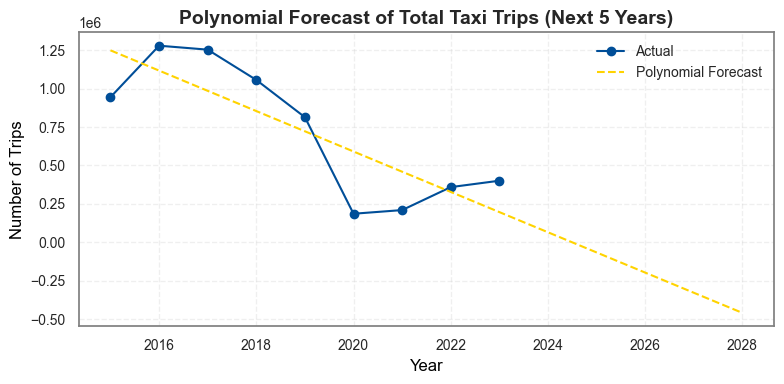

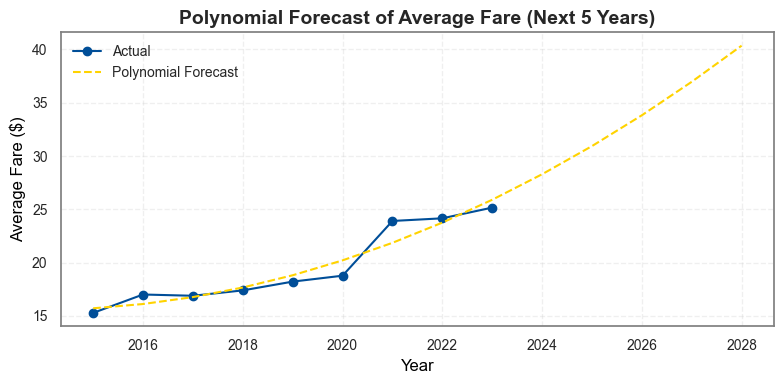

In [223]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def fit_and_forecast_poly(df, x_col, y_col, degree=2, years_forward=5):
    X = df[[x_col]].values
    y = df[y_col].values

    # Polynomial model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)

    # Forecast future years
    last_year = df[x_col].max()
    future_years = np.arange(last_year + 1, last_year + 1 + years_forward)
    all_years = np.append(df[x_col].values, future_years)
    X_all = all_years.reshape(-1, 1)

    # Predict
    y_pred = model.predict(X_all)
    return all_years, y_pred
years_trips_poly, predicted_trips_poly = fit_and_forecast_poly(trips_per_year, "start_year", "num_trips", degree=2)

plt.figure(figsize=(8, 4))
plt.plot(trips_per_year["start_year"], trips_per_year["num_trips"], marker='o', label="Actual", color=PRIMARY_BLUE)
plt.plot(years_trips_poly, predicted_trips_poly, linestyle="--", label="Polynomial Forecast", color=TAXI_YELLOW)
plt.title("Polynomial Forecast of Total Taxi Trips (Next 5 Years)")
plt.xlabel("Year")
plt.ylabel("Number of Trips")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
years_fare_poly, predicted_fare_poly = fit_and_forecast_poly(fare_per_year, "start_year", "avg_fare", degree=2)

plt.figure(figsize=(8, 4))
plt.plot(fare_per_year["start_year"], fare_per_year["avg_fare"], marker='o', label="Actual", color=PRIMARY_BLUE)
plt.plot(years_fare_poly, predicted_fare_poly, linestyle="--", label="Polynomial Forecast", color=TAXI_YELLOW)
plt.title("Polynomial Forecast of Average Fare (Next 5 Years)")
plt.xlabel("Year")
plt.ylabel("Average Fare ($)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# 6. Narrative Genre & Structure (from Segel & Heer)
- What genre are you using? (e.g., "drill-down story", "interactive slideshow", "explanatory video")
- Justify it: why is that right for your audience?
- Refer to Figure 7: which tools did you use from:
  - Visual Narrative (e.g., zooming, filtering, annotation, highlighting)
  - Narrative Structure (e.g., ordering, grouping, transitions)

# 7. Visualizations
- Describe which visualizations are used in the website
- Why were they selected?
- Which are interactive (e.g., filters, tooltips, time sliders)?

# 8. Discussion
- What worked well?
- What limitations does the data have?
- What would you improve (e.g., adding more external context)?

# 9. Contributions
- Mateusz: x
- Jakub: x